# VAE

We want to model $p(x)$.

Assuming some latent factors, $p(x) = \int p(x | z) p(z) dz$. However, $p(x | z)$ is a neural network, so this integral has no closed form and is therefore intractable.

What if we had the posterior $p(z | x)$ to tell us which are the most important $z$ in this integral? Then instead of having to integrate over infinitely many $z$, we could sample from the most important ones. $p(x) = \int p(x, z) dz = \int p(z | x) \frac{p(x, z)}{p(z | x)} dz = \mathbb{E}_{z \sim p(z | x)} \left[ \frac{p(x, z)}{p(z | x)} \right]$. This looks very promising. For every data point $x$, we can just sample $z$ from the posterior, and compute $\frac{p(x, z)}{p(z | x)}$. The posterior $p(z | x)$ is our guide in latent space, showing us the most probable $z$ so we don't have to go to every $z$, just sample and correct for the sampling bias.

Can we compute $p(z | x)$? $p(z | x) = \frac{p(x, z)}{p(x)}$, so no, the denominator is the value we wanted to find in the first place.

We approximate $p(z | x) \approx q_\phi(z | x)$. So, $p(x) = \int p(x, z) dz = \int q_\phi(z | x) \frac{p(x, z)}{q_\phi(z | x)} dz = \mathbb{E}_{z \sim q_\phi(z | x)} \left[ \frac{p(x, z)}{q_\phi(z | x)} \right]$.

Taking logs: $\log p(x) = \log \mathbb{E}_{z \sim q_\phi(z | x)} \left[ \frac{p(x, z)}{q_\phi(z | x)} \right]$.

By Jensen's Inequality (log is concave): $\log \mathbb{E}_{z \sim q_\phi(z | x)} \left[ \frac{p(x, z)}{q_\phi(z | x)} \right] \ge \mathbb{E}_{z \sim q_\phi(z | x)} \left[ \log \frac{p(x, z)}{q_\phi(z | x)} \right]$

So $\log p(x) \ge \mathbb{E}_{z \sim q_\phi(z | x)} \left[ \log \frac{p(x, z)}{q_\phi(z | x)} \right]$ (RHS is ELBO).

$\mathbb{E}_{z \sim q_\phi(z | x)} \left[ \log \frac{p(x, z)}{q_\phi(z | x)} \right] = \mathbb{E}_{z \sim q_\phi(z | x)} \log p(x | z) + \mathbb{E}_{z \sim q_\phi(z | x)} \log \frac{p(z)}{q_\phi(z | x)} = \mathbb{E}_{z \sim q_\phi(z | x)} \log p(x | z) - \text{KL} \left[ q_\phi(z | x) || p(z) \right]$

Maximize $\log p(x) \ge \mathbb{E}_{z \sim q_\phi(z | x)} \log p_\theta(x | z) - \text{KL} \left[ q_\phi(z | x) || p(z) \right]$. The term on the left encourages good reconstructions from latent codes. The KL regularization term penalizes the posterior from deviating too far away from the latent prior.

So minimize $L = -\mathbb{E}_{z \sim q_\phi(z | x)} \log p_\theta(x | z) + \text{KL} \left[ q_\phi(z | x) || p(z) \right]$.

We have to sample $z \sim q_\phi(z | x)$. Using the Reparameterization Trick: $z \sim q_\phi(z | x) = N(\mu_\phi(x), \sigma_\phi^2(x) I)$, sample $z = \mu_\phi(x) + \sigma_\phi(x) \odot \epsilon, \epsilon \sim N(0, I)$

Assuming $p_\theta(x | z) = N(\mu_\theta(z), I)$: $\log p_\theta(x | z) \approx -\frac{1}{2} ||x - \mu_\theta(z)||^2$

Assuming $p(z) = N(0, I)$: $\text{KL} \left[ q_\phi(z | x) || p(z) \right] = \text{KL} \left[ N(\mu_\phi(x), \sigma_\phi^2(x) I) || N(0, I) \right] = \frac{1}{2} \sum_i \left[ \mu_{\phi, i}^2(x) + \sigma_{\phi, i}^2(x) -\log \sigma_{\phi, i}^2(x) - 1\right]$

tensor(-1.) tensor(1.)
torch.Size([60000, 1, 28, 28])


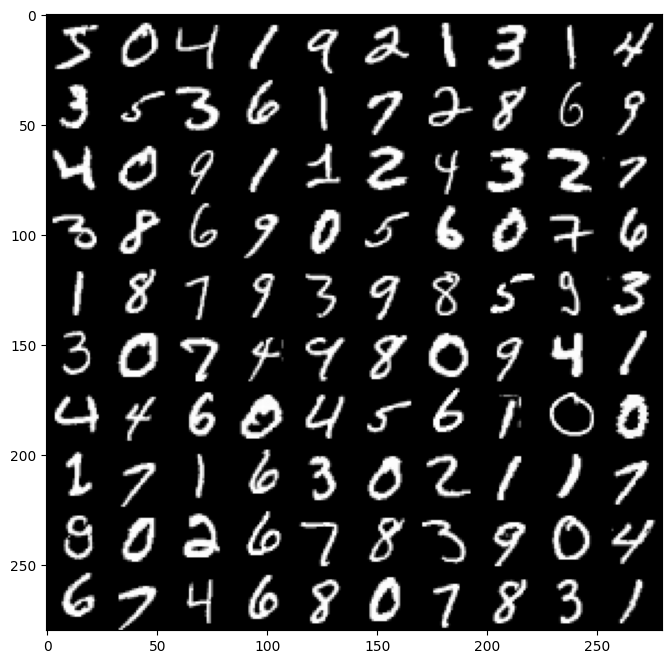

In [1]:
import torch
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST
from einops import rearrange

ds = MNIST(root="data", train=True, download=True)
images, labels = ds.data, ds.targets

images = images.to(dtype=torch.float32)
images = (images - images.min()) / (images.max() - images.min())
images = (images * 2) - 1
print(images.min(), images.max())
images = images.unsqueeze(-3)
print(images.shape)

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(rearrange(images[:100], "(n b) c h w -> (n h) (b c w)", n=10), cmap="grey");
plt.show()

In [2]:
from torch import nn

class VAE(nn.Module):
    def __init__(self, latent_dim: int, hidden_dim: int):
        super().__init__()
        self.enc = nn.Sequential(
            nn.Linear(784, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )
        self.mean_head = nn.Linear(hidden_dim, latent_dim)
        self.log_var_head = nn.Linear(hidden_dim, latent_dim)

        self.dec = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 784)
        )

    def forward(self, x: torch.Tensor):
        x = rearrange(x, "b c h w -> b (c h w)")
        int_z = self.enc(x)
        means = self.mean_head(int_z)
        log_vars = self.log_var_head(int_z)

        stds = (0.5 * log_vars).exp()
        zs = means + stds * torch.randn_like(means)

        x_recon = self.dec(zs)
        x_recon = rearrange(x_recon, "b (c h w) -> b c h w", c=1, h=28, w=28)
        return x_recon, means, log_vars, stds 

In [5]:
from torch.optim import Adam
import wandb

TRAIN_STEPS = 10_001
BATCH_SIZE = 64
BETA = 0.1
LR = 3e-4

vae = VAE(10, 128).to("cuda")
optim = Adam(vae.parameters(), lr=LR)
images = images.to("cuda")

run = wandb.init(
    entity="gbc24001-university-of-connecticut",
    project="vae",
    config={"lr": LR, "beta": BETA, "batch size": BATCH_SIZE}
)

for step in range(TRAIN_STEPS):
    xb = images[torch.randint(len(images), (BATCH_SIZE,))]

    x_recon, means, log_vars, stds = vae(xb)

    recon_loss = 0.5 * ((xb - x_recon) ** 2.0).sum(dim=(1, 2, 3)).mean()
    kl = 0.5 * ((means ** 2) + (stds ** 2) - log_vars - 1).sum(dim=1).mean()
    loss = recon_loss + BETA * kl

    optim.zero_grad(set_to_none=True)
    loss.backward()
    optim.step()

    if step % 100 == 0:
        run.log({"loss": loss, "recon_loss": recon_loss, "kl": kl}, step=step)

        recon_images = torch.stack((xb[:10].detach().to("cpu"), x_recon[:10].detach().to("cpu")))
        recon_images = rearrange(recon_images, "n b c h w -> c (n h) (b w)")
        recon_images = ((recon_images.clip(-1, 1) + 1) * (255 / 2)).to(dtype=torch.uint8)
        run.log({"recons": wandb.Image(recon_images)}, step=step)

    if step % 1_000 == 0:
        print(f"{step:6d}: loss={loss:.4f}   recon_loss={loss:.4f}   kl={kl:.4f}")

        with torch.no_grad():
            _, zs, _, _ = vae(images[:5000])
            u, s, vh = torch.linalg.svd(zs, full_matrices=False)
            zs_2d = (u[:, :2] * s[:2]).cpu()
        plt.figure(figsize=(8, 6))
        plt.scatter(zs_2d[:, 0], zs_2d[:, 1], c=labels[:5000], alpha=0.8, cmap=plt.get_cmap("jet", 10))
        run.log({"latent2d": plt}, step=step)

run.finish()

     0: loss=365.4648   recon_loss=365.4648   kl=0.0603
  1000: loss=57.9557   recon_loss=57.9557   kl=27.2851
  2000: loss=48.4230   recon_loss=48.4230   kl=27.3882
  3000: loss=45.0545   recon_loss=45.0545   kl=27.4838
  4000: loss=45.3484   recon_loss=45.3484   kl=27.5490
  5000: loss=43.8839   recon_loss=43.8839   kl=26.4472
  6000: loss=47.1391   recon_loss=47.1391   kl=26.0525
  7000: loss=37.7272   recon_loss=37.7272   kl=27.3799
  8000: loss=42.1578   recon_loss=42.1578   kl=26.4626
  9000: loss=39.9869   recon_loss=39.9869   kl=27.6732
 10000: loss=38.0080   recon_loss=38.0080   kl=27.1804


kl,▁▄▆▇▇▇▆█▇▇█▇▇▇▇▇▇▇▆▇▆▆▆▇▆▇▆▆▆▆▆▆▆▇▇▆▇▇▇▇
loss,█▆▄▄▃▃▂▂▂▂▃▂▂▂▂▂▂▂▂▂▂▁▂▂▂▁▂▁▁▂▂▂▁▁▂▁▂▂▁▁
recon_loss,█▆▅▄▄▃▃▂▂▂▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▂▁▁▂▂▁▁▂▁
kl,27.18035
loss,38.008
recon_loss,35.28996
